<a href="https://colab.research.google.com/github/ChrisHallak/Sentiment-analysis-of-COVID-19-vaccine-through-tweets/blob/main/Comparing_ML_with_DL_for_COVID_19_Vaccine_Syntiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step [1]: Prepare libraries and data

## [1.1] Include important libraries

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras import layers
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pandas as pd
import arabicstopwords.arabicstopwords as stp
from nltk.tokenize import word_tokenize
from bidi.algorithm import get_display
import qalsadi.lemmatizer
import unicodedata as ud
import arabic_reshaper
import string
import re
import nltk
import emoji
import numpy as np



lemmer = qalsadi.lemmatizer.Lemmatizer()
sw = stp.stopwords_list()




## [1.2] read data from csv file

In [ ]:
df_train = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\train.csv')
df_test = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\test.csv')
df_valid = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\valid.csv')

## إزالة التغريدات التي تصنيفها 2و3 والاكتفاء فقط بالتغريدات ذات التصنبيف 1و0
df_train = df_train[df_train['label'] <= 1]
df_test = df_test[df_test['label'] <= 1]
df_valid = df_valid[df_valid['label'] <= 1]


In [ ]:
df_train.head()

,tweet,label
1,'#خذ_الخطوة_خذ_اللقاح \nالحمدالله من قبل ومن ب...,1
2,لو اللي مثلك وشرواك طعمو كان قد حذفنا الكمامات...,1
3,#الصحة:•نحو 14.5 مليون شخص تم إعطاؤهم جرعة لقا...,1
8,بوتين يحصل مجددًا على لقاح مضاد لفيروس كورونا ...,1
9,تسعى شركه مودرنا الأمريكيه لاستصدار ترخيص من ه...,1


## [1.3] Prapere The Comparison Dictionary

In [ ]:
model_comparison_table = {}

model_comparison_table['model_name'] = []
model_comparison_table['preprocessing_methods'] = []
model_comparison_table['accuracy'] = []

## Function to  get ( x_train,y_train,x_test,y_test,x_valid,y_valid) from the dataframes

In [ ]:
# تابع يرد قيم عمود معين من جدول التدريب والاختبار والتحقق ويحولها إلى ليست
def get_values(datafield):
    x_train = df_train[datafield].values
    y_train = df_train['label'].values
    x_test = df_test[datafield].values
    y_test = df_test['label'].values
    x_valid =df_valid[datafield].values
    y_valid = df_valid['label'].values
    return x_train,y_train,x_test,y_test,x_valid,y_valid



## Function to apply bag of words

In [ ]:
def apply_bagOfWords(x_train,x_test,x_valid):
    vectorizer = CountVectorizer()

    # عملية استخراج المفردات من معطيات التدريب
    vectorizer.fit(x_train)

    # نقل عملية التعلم إلى معطيات الاختبار والتحقق
    X_train = vectorizer.transform(x_train)
    X_test = vectorizer.transform(x_test)
    X_valid = vectorizer.transform(x_valid)

    print("shape of X_train : " , X_train.toarray().shape)
    print("shape of X_test : " , X_test.toarray().shape)
    print("shape of X_valid : ",X_valid.toarray().shape)

    return X_train,X_test,X_valid

## Function to apply TF-IDF

In [ ]:
def apply_tfidf(x_train,x_test,x_valid,min_df,max_df):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1, 2))
    vectorizer.fit(x_train)
    X_train = vectorizer.transform(x_train)
    X_test = vectorizer.transform(x_test)
    X_valid = vectorizer.transform(x_valid)
    print("shape of X_train : " , X_train.toarray().shape)
    print("shape of X_test : " , X_test.toarray().shape)
    print("shape of X_valid : ",X_valid.toarray().shape)
    return X_train,X_test,X_valid


## Function to apply TF-IDF 3-Grams

In [ ]:
def apply_tfidf_3grams(x_train,x_test,x_valid,min_df,max_df):
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1, 3))
    vectorizer.fit(x_train)
    X_train = vectorizer.transform(x_train)
    X_test = vectorizer.transform(x_test)
    X_valid = vectorizer.transform(x_valid)
    print("shape of X_train : " , X_train.toarray().shape)
    print("shape of X_test : " , X_test.toarray().shape)
    print("shape of X_valid : ",X_valid.toarray().shape)
    return X_train,X_test,X_valid

## Function to apply word embedding

In [ ]:
def apply_wordEmbedding(x_train,x_test,x_valid):

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(x_train)

    X_train = tokenizer.texts_to_sequences(x_train)
    X_test = tokenizer.texts_to_sequences(x_test)
    X_valid  = tokenizer.texts_to_sequences(x_valid)

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    return X_train,X_test,x_valid,vocab_size


## Function to train logistic regression model

In [ ]:
def build_logistic(X_train,y_train,X_test,y_test):
    model = LogisticRegression(max_iter = 200)
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    score = accuracy_score(y_test, y_predicted)
    return y_predicted,score


## Function to train SVM model

In [ ]:
def build_SVM(X_train,y_train,X_test,y_test):
    model = svm.SVC(kernel="linear")
    model.fit(X_train,y_train)
    y_predicted = model.predict(X_test)
    score = accuracy_score(y_test, y_predicted)
    return y_predicted,score

## Function to train Nearest Neighbors model

In [ ]:
def build_nearestNeighbors(X_train,y_train,X_test,y_test):
    model = NearestCentroid()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    score = accuracy_score(y_test, y_predicted)
    return y_predicted,score



## Function to plot history

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Step [2]: Cleaning and Normalization

In [ ]:
def remove_mentions(tweet,work = 1):
    if work == 1:
        tweet = re.sub(r"@\S+", '', tweet)
    return tweet
#---------------------------------------------

def remove_hyperlinks(tweet,work=1):
    if work == 1:
        tweet = re.sub(r'https?\S+', '', tweet)
    return tweet
#---------------------------------------------

def remove_non_arabic_characters(tweet,work=1):
    if work == 1:
        tweet = re.sub(r"[^\u0600-\u06FF]+", " ",tweet);
    return tweet
#---------------------------------------------

def remove_extraLetters(tweet,work =1):
    if work == 1:
        tweet = re.sub(r'(.)\1+', r'\1', tweet)
    return tweet
#---------------------------------------------

def remove_punctuations(tweet,work = 1):
    if work == 1 :
        arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
        english_punctuations = string.punctuation
        punctuations_list = arabic_punctuations + english_punctuations
        translator = str.maketrans(' ', ' ', punctuations_list)
        return tweet.translate(translator)
    else :
        return tweet
#---------------------------------------------

def remove_stopwords(tweet,work = 1):
    if work == 1:
        tokens = tweet.split()
        tweet = " ".join([token for token in  tokens if token not in sw])
    return tweet
#---------------------------------------------

def normalize_arabic(tweet,work = 1):
    if work == 1:
        tweet = re.sub("[إأآا]", "ا", tweet)
        tweet = re.sub("ى", "ي", tweet)
        tweet = re.sub("ؤ", "ء", tweet)
        tweet = re.sub("ئ", "ء", tweet)
        tweet = re.sub("ة", "ه", tweet)
        tweet = re.sub("گ", "ك", tweet)
        return tweet
    else :
        return tweet
#---------------------------------------------

def lemmatization(tweet ,work = 1):
    if work == 1:
        lemmas = lemmer.lemmatize_text(tweet)
        return " ".join(lemmas)
    else :
        return tweet

In [ ]:
# flag 0 removing mentions
# flag 1 removing hyperlinks
# flag 2 removing non_arabic_chars
# flag 3 remove extra letters
# flag 4 remove puncs
# flag 5 remove stopwords
# flag 6 normalization
# flag 7 lemmatization

def preprocess(tweet,flags):
    tweet = remove_mentions(tweet,flags[0])
    tweet = remove_hyperlinks(tweet,flags[1])
    tweet = remove_non_arabic_characters(tweet,flags[2])
    tweet = remove_extraLetters(tweet,flags[3])
    tweet = remove_punctuations(tweet,flags[4])
    tweet = remove_stopwords(tweet,flags[5])
    tweet = normalize_arabic(tweet,flags[6])
    tweet = lemmatization(tweet,flags[7])
    return tweet

# Functions to evaluate Classification Models

### function to plot confusion matrix

In [ ]:
def plot_confusion_matrix(y_test,y_predicted,score):
    cm = metrics.confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuPu');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size = 13);

###  function to print classification model report

In [ ]:
def print_model_report(y_test,y_predicated):
    print("_____________________________________________________")
    print(classification_report(y_test, y_predicted))
    print("_____________________________________________________")


# Step [2]: Build Baseline

## [2.1] Extract Bag of Words Features

In [ ]:

x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('tweet')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)


shape of X_train :  (8117, 42641)
shape of X_test :  (2717, 42641)
shape of X_valid :  (2688, 42641)


## [2.2] Train model

In [ ]:
y_predicted , basemodelACC = build_logistic(X_train,y_train,X_test,y_test)

print("BaseLine Model Accuracy : ",basemodelACC)

BaseLine Model Accuracy :  0.7765918292234082


## [2.3] Evaluation

### [2.3.1] Confusion Matrix

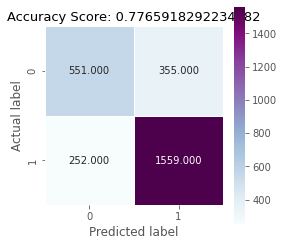

In [ ]:
plot_confusion_matrix(y_test,y_predicted,basemodelACC)

### [2.3.2] Classification Report

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.61      0.64       906
           1       0.81      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.78      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("none")
model_comparison_table['accuracy'].append(basemodelACC)

# Step [3]: Build model with preprocessing methods

## Step [3.1]: Build model after removing mentions

In [ ]:
df_train['without_mentions'] = df_train['tweet'].apply(lambda x : preprocess(x,[1,0,0,0,0,0,0,0]))
df_test['without_mentions'] = df_test['tweet'].apply(lambda x : preprocess(x,[1,0,0,0,0,0,0,0]))
df_valid['without_mentions'] = df_valid['tweet'].apply(lambda x : preprocess(x,[1,0,0,0,0,0,0,0]))

### Step [3.1.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_mentions')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)


shape of X_train :  (8117, 39727)
shape of X_test :  (2717, 39727)
shape of X_valid :  (2688, 39727)


### Step [3.1.2]: Train model

In [ ]:
y_predicted , withoutmentionsACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy after removing mentions: ",withoutmentionsACC)



Model Accuracy after removing mentions:  0.770702981229297


### Step [3.1.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       906
           1       0.81      0.86      0.83      1811

    accuracy                           0.77      2717
   macro avg       0.74      0.73      0.73      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions")
model_comparison_table['accuracy'].append(withoutmentionsACC)

## Step [3.2]: Build model after removing urls

In [ ]:
df_train['without_urls'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_test['without_urls'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_valid['without_urls'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))

### Step [3.2.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_urls')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 38741)
shape of X_test :  (2717, 38741)
shape of X_valid :  (2688, 38741)


### Step [3.2.2]: Train model

In [ ]:
y_predicted , withouturlsACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy after removing urls : ",withouturlsACC)


Model Accuracy after removing urls :  0.7769598822230401


### Step [3.2.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.60      0.64       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.78      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing urls")
model_comparison_table['accuracy'].append(withouturlsACC)

## Step [3.3]: Build model after removing non_arabic characters

In [ ]:
df_train['without_nonArabicChars'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))
df_test['without_nonArabicChars'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))
df_valid['without_nonArabicChars'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))

### Step [3.3.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_nonArabicChars')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 33812)
shape of X_test :  (2717, 33812)
shape of X_valid :  (2688, 33812)


### Step [3.3.2]: Train model

In [ ]:
y_predicted , withoutNonArabicACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing non-arabic characters: ",withoutNonArabicACC)


Model Accuracy After removing non-arabic characters:  0.7732793522267206


### Step [3.3.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       906
           1       0.81      0.86      0.84      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing non-arabic characters")
model_comparison_table['accuracy'].append(withoutNonArabicACC)

## Step [3.4]: Build model after extra characters

In [ ]:
df_train['without_extra'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_test['without_extra'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_valid['without_extra'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))

### Step [3.4.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_extra')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 41689)
shape of X_test :  (2717, 41689)
shape of X_valid :  (2688, 41689)


### Step [3.4.2]: Train model

In [ ]:
y_predicted , withoutextraACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing extra characters: ",withoutextraACC)


Model Accuracy After removing extra characters:  0.7795362532204637


### Step [3.2.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.61      0.65       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.75      0.74      0.74      2717
weighted avg       0.77      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing extra chars")
model_comparison_table['accuracy'].append(withoutextraACC)

## Step [3.5]: Build model after removing punctuations

In [ ]:
df_train['without_puncs'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))
df_test['without_puncs'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))
df_valid['without_puncs'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))

### Step [3.5.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_puncs')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 43308)
shape of X_test :  (2717, 43308)
shape of X_valid :  (2688, 43308)


### Step [3.5.2]: Train model

In [ ]:
y_predicted , withoutpuncsACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing punctuations : ",withoutpuncsACC)


Model Accuracy After removing punctuations :  0.7740154582259845


### Step [3.5.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       906
           1       0.81      0.86      0.84      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing punctuations")
model_comparison_table['accuracy'].append(withoutpuncsACC)

## Step [3.6]: Build model after removing stop words

In [ ]:
df_train['without_stop'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,1,0,0]))
df_test['without_stop'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,1,0,0]))
df_valid['without_stop'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,1,0,0]))

### Step [3.6.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('without_stop')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 42083)
shape of X_test :  (2717, 42083)
shape of X_valid :  (2688, 42083)


### Step [3.6.2]: Train model

In [ ]:
y_predicted , withoutstopsACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing stop words : ",withoutstopsACC)


Model Accuracy After removing stop words :  0.7747515642252485


### Step [3.6.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.63       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing stop words")
model_comparison_table['accuracy'].append(withoutstopsACC)

## Step [3.7]: Build model after normalization

In [ ]:
df_train['norm'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,0,1,0]))
df_test['norm'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,0,1,0]))
df_valid['norm'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,0,0,0,0,1,0]))

### Step [3.7.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('norm')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 39907)
shape of X_test :  (2717, 39907)
shape of X_valid :  (2688, 39907)


### Step [3.7.2]: Train model

In [ ]:
y_predicted , normalizationACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After normalization : ",normalizationACC)


Model Accuracy After normalization :  0.771071034228929


### Step [3.7.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       906
           1       0.81      0.86      0.83      1811

    accuracy                           0.77      2717
   macro avg       0.74      0.73      0.73      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("normalization")
model_comparison_table['accuracy'].append(normalizationACC)

## Step [3.8]: Build model after lemmatization

In [ ]:
df_train['lemma'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,1,0,0,1]))
df_test['lemma'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,1,0,0,1]))
df_valid['lemma'] = df_valid['tweet'].apply(lambda x : preprocess(x,[0,0,1,0,1,0,0,1]))

### Step [3.8.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 15570)
shape of X_test :  (2717, 15570)
shape of X_valid :  (2688, 15570)


### Step [3.8.2]: Train model

In [ ]:
y_predicted , lemmatizationACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After lemmatization : ",lemmatizationACC)


Model Accuracy After lemmatization :  0.7835848362164152


### Step [3.8.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("lemmatization")
model_comparison_table['accuracy'].append(lemmatizationACC)

## Step [3.9]: Build model after removing mentions,urls

In [ ]:
df_train['op12'] = df_train['without_mentions'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_test['op12'] = df_test['without_mentions'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_valid['op12'] = df_valid['without_mentions'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))

### Step [3.9.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op12')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 35876)
shape of X_test :  (2717, 35876)
shape of X_valid :  (2688, 35876)


### Step [3.9.2]: Train model

In [ ]:
y_predicted , op12ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions and urls : ",op12ACC)


Model Accuracy After removing mentions and urls :  0.7721751932278248


### Step [3.9.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       906
           1       0.81      0.86      0.83      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.73      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions and urls")
model_comparison_table['accuracy'].append(op12ACC)

## Step [3.10]: Build model after removing mentions,urls and non-arabic chars

In [ ]:
df_train['op123'] = df_train['op12'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))
df_test['op123'] = df_test['op12'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))
df_valid['op123'] = df_valid['op12'].apply(lambda x : preprocess(x,[0,0,1,0,0,0,0,0]))

### Step [3.10.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op123')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 33773)
shape of X_test :  (2717, 33773)
shape of X_valid :  (2688, 33773)


### Step [3.10.2]: Train model

In [ ]:
y_predicted , op123ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions, urls and non-arabic chars: ",op123ACC)


Model Accuracy After removing mentions, urls and non-arabic chars:  0.7743835112256164


### Step [3.10.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.63       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions,urls,non-arabic")
model_comparison_table['accuracy'].append(op123ACC)

## Step [3.11]: Build model after removing mentions,urls , non-arabic and extra characters

In [ ]:
df_train['op1234'] = df_train['op123'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_test['op1234'] = df_test['op123'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_valid['op1234'] = df_valid['op123'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))

### Step [3.11.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op1234')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 32919)
shape of X_test :  (2717, 32919)
shape of X_valid :  (2688, 32919)


### Step [3.11.2]: Train model

In [ ]:
y_predicted , op1234ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions, urls , non-arabic and extra characters: ",op1234ACC)


Model Accuracy After removing mentions, urls , non-arabic and extra characters:  0.7747515642252485


### Step [3.11.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.77      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.77      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions,urls,non-arabic and extra chars")
model_comparison_table['accuracy'].append(op1234ACC)

## Step [3.12]: removing mentions,urls , non-arabic , extra characters and punctuations

In [ ]:
df_train['op12345'] = df_train['op1234'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))
df_test['op12345'] = df_test['op1234'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))
df_valid['op12345'] = df_valid['op1234'].apply(lambda x : preprocess(x,[0,0,0,0,1,0,0,0]))

### Step [3.12.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op12345')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 32965)
shape of X_test :  (2717, 32965)
shape of X_valid :  (2688, 32965)


### Step [3.12.2]: Train model

In [ ]:
y_predicted , op12345ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions, urls , non-arabic , extra characters and punctuations: ",op12345ACC)


Model Accuracy After removing mentions, urls , non-arabic , extra characters and punctuations:  0.7754876702245124


### Step [3.11.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.78      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions,urls,non-arabic,extra chars and punctuations")
model_comparison_table['accuracy'].append(op12345ACC)

## Step [3.13]: removing urls, extra characters

In [ ]:
df_train['op24'] = df_train['tweet'].apply(lambda x : preprocess(x,[0,1,0,1,0,0,0,0]))
df_test['op24'] = df_test['tweet'].apply(lambda x : preprocess(x,[0,1,0,1,0,0,0,0]))
df_valid['op24'] = df_valid['tweet'].apply(lambda x :preprocess(x,[0,1,0,1,0,0,0,0]))

### Step [3.13.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op24')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 37791)
shape of X_test :  (2717, 37791)
shape of X_valid :  (2688, 37791)


### Step [3.13.2]: Train model

In [ ]:
y_predicted , op24ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing urls and extra characters : ",op24ACC)


Model Accuracy After removing urls and extra characters :  0.7788001472211998


### Step [3.13.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.70      0.60      0.64       906
           1       0.81      0.87      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.75      0.73      0.74      2717
weighted avg       0.77      0.78      0.77      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing urls and extra characters")
model_comparison_table['accuracy'].append(op24ACC)

## Step [3.14]: removing urls, extra characters and lemmatization

In [ ]:
df_train['op2348'] = df_train['lemma'].apply(lambda x : preprocess(x,[0,1,0,1,0,0,0,0]))
df_test['op2348'] = df_test['lemma'].apply(lambda x : preprocess(x,[0,1,0,1,0,0,0,0]))
df_valid['op2348'] = df_valid['lemma'].apply(lambda x :preprocess(x,[0,1,0,1,0,0,0,0]))

### Step [3.14.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op2348')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 15288)
shape of X_test :  (2717, 15288)
shape of X_valid :  (2688, 15288)


### Step [3.14.2]: Train model

In [ ]:
y_predicted , op2348ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing urls, extra,non arabic chars and lemmatization: ",op2348ACC)


Model Accuracy After removing urls, extra,non arabic chars and lemmatization:  0.7824806772175193


### Step [3.14.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing urls,extra ,non-arabic and lemmatization")
model_comparison_table['accuracy'].append(op2348ACC)

## Step [3.15]: removing mentions and lemmatization

In [ ]:
df_train['op18'] = df_train['lemma'].apply(lambda x : preprocess(x,[1,0,0,0,0,0,0,0]))
df_test['op18'] = df_test['lemma'].apply(lambda x : preprocess(x,[1,0,0,0,0,0,0,0]))
df_valid['op18'] = df_valid['lemma'].apply(lambda x :preprocess(x,[1,0,0,0,0,0,0,0]))

### Step [3.15.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op18')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 15570)
shape of X_test :  (2717, 15570)
shape of X_valid :  (2688, 15570)


### Step [3.15.2]: Train model

In [ ]:
y_predicted , op18ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions and lemmatization: ",op18ACC)


Model Accuracy After removing mentions and lemmatization:  0.7835848362164152


### Step [3.13.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing mentions and lemmatization")
model_comparison_table['accuracy'].append(op18ACC)

## Step [3.16]: removing urls and lemmatization

In [ ]:
df_train['op28'] = df_train['lemma'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_test['op28'] = df_test['lemma'].apply(lambda x : preprocess(x,[0,1,0,0,0,0,0,0]))
df_valid['op28'] = df_valid['lemma'].apply(lambda x :preprocess(x,[0,1,0,0,0,0,0,0]))

### Step [3.16.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op28')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 15570)
shape of X_test :  (2717, 15570)
shape of X_valid :  (2688, 15570)


### Step [3.16.2]: Train model

In [ ]:
y_predicted , op28ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing urls and lemmatization: ",op28ACC)


Model Accuracy After removing urls and lemmatization:  0.7835848362164152


### Step [3.16.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing urls and lemmatization")
model_comparison_table['accuracy'].append(op28ACC)

## Step [3.17]: removing extra chars and lemmatization

In [ ]:
df_train['op48'] = df_train['lemma'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_test['op48'] = df_test['lemma'].apply(lambda x : preprocess(x,[0,0,0,1,0,0,0,0]))
df_valid['op48'] = df_valid['lemma'].apply(lambda x :preprocess(x,[0,0,0,1,0,0,0,0]))

### Step [3.17.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op48')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 15288)
shape of X_test :  (2717, 15288)
shape of X_valid :  (2688, 15288)


### Step [3.17.2]: Train model

In [ ]:
y_predicted , op48ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing extra chars and lemmatization: ",op48ACC)


Model Accuracy After removing extra chars and lemmatization:  0.7824806772175193


### Step [3.17.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing extra chars and lemmatization")
model_comparison_table['accuracy'].append(op48ACC)

## Step [3.18]:  mentions,urls,extra,stop-words,puncs,normalization and lemmatization

In [ ]:
df_train['op12345678'] = df_train['lemma'].apply(lambda x : preprocess(x,[1,1,1,1,1,1,1,0]))
df_test['op12345678'] = df_test['lemma'].apply(lambda x : preprocess(x,[1,1,1,1,1,1,1,0]))
df_valid['op12345678'] = df_valid['lemma'].apply(lambda x :preprocess(x,[1,1,1,1,1,1,1,0]))

### Step [3.18.1]: Extract Bag of words features

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('op12345678')
X_train,X_test,X_valid = apply_bagOfWords(x_train,x_test,x_valid)

shape of X_train :  (8117, 14245)
shape of X_test :  (2717, 14245)
shape of X_valid :  (2688, 14245)


### Step [3.18.2]: Train model

In [ ]:
y_predicted , op12345678ACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy After removing mentions,urls,extra,non-arabic,stopwords, normalization lemmatization: ",op12345678ACC)


Model Accuracy After removing mentions,urls,extra,non-arabic,stopwords, normalization lemmatization:  0.7813765182186235


### Step [3.18.3]: Evaluation model

In [ ]:
print_model_report(y_test,y_predicted)

_____________________________________________________
              precision    recall  f1-score   support

           0       0.69      0.62      0.65       906
           1       0.82      0.86      0.84      1811

    accuracy                           0.78      2717
   macro avg       0.76      0.74      0.75      2717
weighted avg       0.78      0.78      0.78      2717

_____________________________________________________


In [ ]:
model_comparison_table['model_name'].append("logistic regression with bag of words")
model_comparison_table['preprocessing_methods'].append("removing all noise, normalization and lemmatization")
model_comparison_table['accuracy'].append(op12345678ACC)

# Step [4]: TF-IDF with logistic regression model

## Step [4.1]: Extract TF-IDF  

In [ ]:
## بعد تجريب الكثير من ال min-df و max-df تم الحصول على اعلى دقة عند
## min-df = 4
## max-df = 0.4

x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_tfidf(x_train,x_test,x_valid,4,0.4)


shape of X_train :  (8117, 10042)
shape of X_test :  (2717, 10042)
shape of X_valid :  (2688, 10042)


## Step [4.2]: Train model

In [ ]:
y_predicted , tfidfACC = build_logistic(X_train,y_train,X_test,y_test)

print("Model Accuracy with TF-IDF: ",tfidfACC)


Model Accuracy with TF-IDF:  0.7883695252116305


In [ ]:
model_comparison_table['model_name'].append("logistic regression with td-idf <4,0.4>")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(tfidfACC)

# Step [5]: TF-IDF with SVM model

## Step [5.1]: Extract TF-IDF  

In [ ]:
## بعد تجريب الكثير من ال min-df و max-df تم الحصول على اعلى دقة عند
## min-df = 4
## max-df = 0.4

x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_tfidf(x_train,x_test,x_valid,4,0.4)


shape of X_train :  (8117, 10042)
shape of X_test :  (2717, 10042)
shape of X_valid :  (2688, 10042)


## Step [5.2]: Train model

In [ ]:
y_predicted , svmACC = build_SVM(X_train,y_train,X_test,y_test)

print("SVM Accuracy with TF-IDF: ",svmACC)


SVM Accuracy with TF-IDF:  0.7931542142068457


In [ ]:
model_comparison_table['model_name'].append("SVM classification with td-idf <4,0.4>")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(svmACC)

# Step [6]: TF-IDF(3-Grams) with SVM model

## Step [6.1]: Extract TF-IDF  with 3-Grams

In [ ]:
## بعد تجريب الكثير من ال min-df و max-df تم الحصول على اعلى دقة عند
## min-df = 4
## max-df = 0.4

x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_tfidf_3grams(x_train,x_test,x_valid,4,0.4)


shape of X_train :  (8117, 12606)
shape of X_test :  (2717, 12606)
shape of X_valid :  (2688, 12606)


## Step [6.2]: Train model

In [ ]:
y_predicted , svmACC = build_SVM(X_train,y_train,X_test,y_test)

print("SVM Accuracy with TF-IDF: ",svmACC)


SVM Accuracy with TF-IDF:  0.7949944792050055


In [ ]:
model_comparison_table['model_name'].append("SVM classification with td-idf 3-Grams <4,0.4>")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(svmACC)

# Step [7]: Training with deep neural network

## Step [7.1]: Architecture 1

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_tfidf(x_train,x_test,x_valid,4,0.4)
X_train = X_train.toarray()
X_test = X_test.toarray()
X_valid = X_valid.toarray()

input_dim = X_train.shape[1]  # Number of features
m1 = Sequential()
m1.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
m1.add(layers.Dense(1, activation='sigmoid'))

m1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
m1.summary()



shape of X_train :  (8117, 10042)
shape of X_test :  (2717, 10042)
shape of X_valid :  (2688, 10042)
10042
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 10)                100430    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 100,441
Trainable params: 100,441
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9963
Testing Accuracy:  0.7663


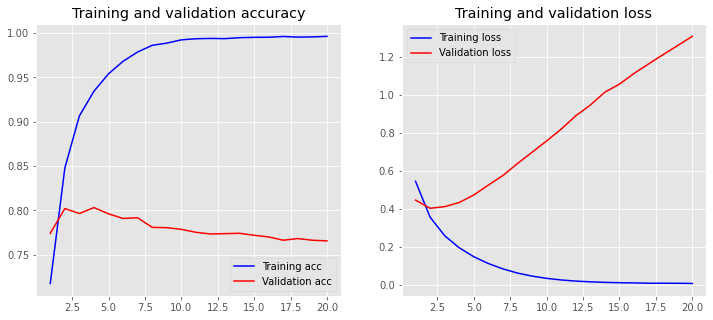

In [ ]:
h1 = m1.fit(X_train, y_train,epochs=20,verbose=False,validation_data=(X_valid, y_valid),batch_size=10)

loss, accuracy1 = m1.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy1))
loss, accuracy1 = m1.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy1))

plot_history(h1)

In [ ]:
model_comparison_table['model_name'].append("1-layer Network with TF_IDF")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(accuracy1)

## Step [7.2]: Architecture 2

In [ ]:
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid = apply_tfidf(x_train,x_test,x_valid,4,0.4)
X_train = X_train.toarray()
X_test = X_test.toarray()
X_valid = X_valid.toarray()

input_dim = X_train.shape[1]  # Number of features
m2 = Sequential()
m2.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
m2.add(layers.Dense(8,activation = 'relu'))
m2.add(layers.Dense(4,activation = 'relu'))
m2.add(layers.Dense(1, activation='sigmoid'))
m2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
m2.summary()

shape of X_train :  (8117, 10042)
shape of X_test :  (2717, 10042)
shape of X_valid :  (2688, 10042)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 10)                100430    
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 5         
Total params: 100,559
Trainable params: 100,559
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9969
Testing Accuracy:  0.7670


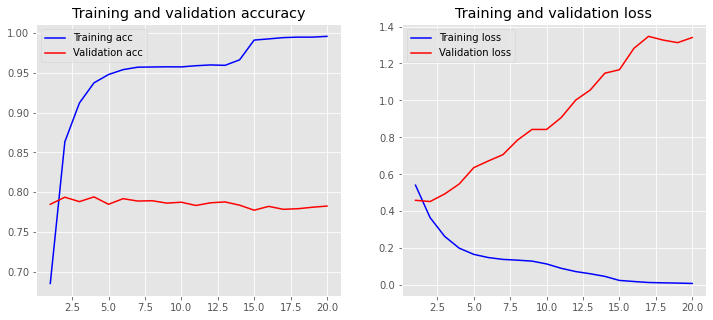

In [ ]:
h2 = m2.fit(X_train, y_train,epochs=20,verbose=False,validation_data=(X_valid, y_valid),batch_size=10)
loss, accuracy2 = m2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy2))
loss, accuracy2 = m2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy2))
plot_history(h2)

In [ ]:
model_comparison_table['model_name'].append("3-layers Network with TF_IDF")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(accuracy2)

# Step [8]: Word Embedding With dense layers

In [ ]:
from keras.preprocessing.text import Tokenizer
x_train,y_train,x_test,y_test,x_valid,y_valid = get_values('lemma')
X_train,X_test,X_valid,vocab_size = apply_wordEmbedding(x_train,x_test,x_valid)


In [ ]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

m3 = Sequential()
m3.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
m3.add(layers.Flatten())
m3.add(layers.Dense(10, activation='relu'))
m3.add(layers.Dense(1, activation='sigmoid'))
m3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
m3.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           780650    
_________________________________________________________________
flatten_3 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                50010     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 830,671
Trainable params: 830,671
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9969
Testing Accuracy:  0.7413


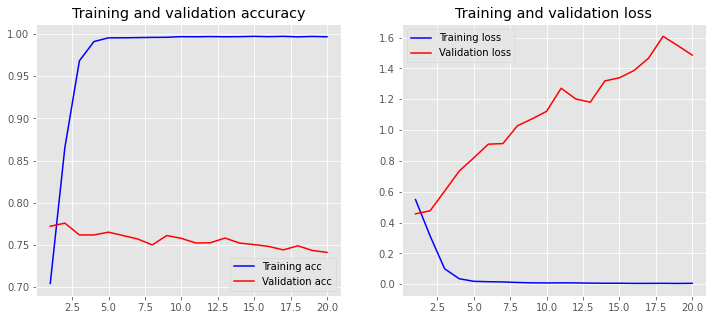

In [ ]:
h3 = m3.fit(X_train, y_train,epochs=20,verbose=False,validation_data=(X_test, y_test),batch_size=10)
loss, accuracy3 = m3.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy3))
loss, accuracy3 = m3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy3))
plot_history(h3)

In [ ]:
model_comparison_table['model_name'].append("1-layer Network with word embedding")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(accuracy3)

# Step [9]: Word Embedding With MaxPooling layers

In [ ]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

m4 = Sequential()
m4.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
m4.add(layers.GlobalMaxPool1D())
m4.add(layers.Dense(10, activation='relu'))
m4.add(layers.Dense(1, activation='sigmoid'))
m4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
m4.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           780650    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 11        
Total params: 781,171
Trainable params: 781,171
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9970
Testing Accuracy:  0.7795


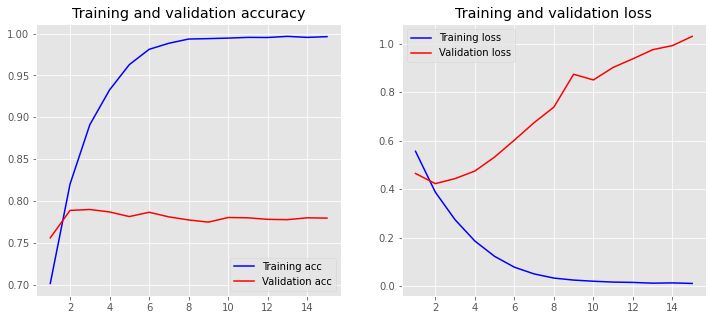

In [ ]:
h4 = m4.fit(X_train, y_train,epochs=15,verbose=False,validation_data=(X_test, y_test),batch_size=10)
loss, accuracy4 = m4.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy4))
loss, accuracy4 = m4.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy4))
plot_history(h4)

In [ ]:
model_comparison_table['model_name'].append("MaxPooling layers with word embedding")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(accuracy4)

# Step [9]: Word Embedding With CNN

In [ ]:
embedding_dim = 100

m5 = Sequential()
m5.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
m5.add(layers.Conv1D(128, 5, activation='relu'))
m5.add(layers.GlobalMaxPooling1D())
m5.add(layers.Dense(10, activation='relu'))
m5.add(layers.Dense(1, activation='sigmoid'))
m5.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
m5.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1561300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 11        
Total params: 1,626,729
Trainable params: 1,626,729
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9978
Testing Accuracy:  0.7792


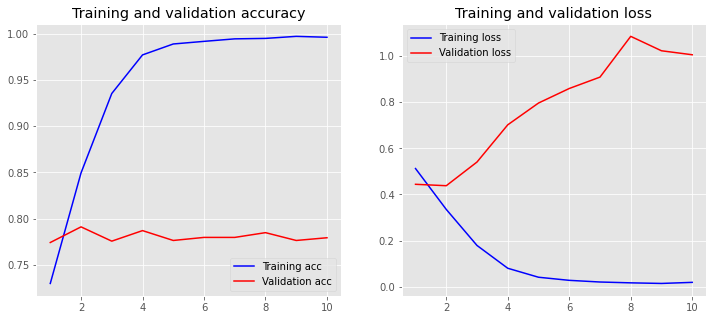

In [ ]:
h5 = m5.fit(X_train, y_train,epochs=10, verbose=False,validation_data=(X_test, y_test),batch_size=10)
loss, accuracy5 = m5.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy5))
loss, accuracy5 = m5.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy5))
plot_history(h5)

In [ ]:
model_comparison_table['model_name'].append("CNN with word embedding")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(accuracy5)

# Step [10]: Training for all classes

In [ ]:
df_train_all = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\train.csv')
df_test_all = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\test.csv')
df_valid_all = pd.read_csv(r'C:\Users\user\Downloads\CoronaHW\Data\valid.csv')


df_train_all['lemma'] = df_train_all['tweet'].apply(lambda x : preprocess(str(x),[0,0,1,0,1,0,0,1]))
df_test_all['lemma'] = df_test_all['tweet'].apply(lambda x : preprocess(str(x),[0,0,1,0,1,0,0,1]))


In [ ]:
x_train = df_train_all['lemma'].values
y_train = df_train_all['label'].values
x_test = df_test_all['lemma'].values
y_test = df_test_all['label'].values
vectorizer = TfidfVectorizer(min_df=4, max_df=0.4, ngram_range=(1, 2))
vectorizer.fit(x_train)
X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)



In [ ]:
#y_predicted , allACC = build_SVM(X_train,y_train,X_test,y_test)
print("all accuracy: ",allACC)

all accuracy:  0.764092163675


In [ ]:
model_comparison_table['model_name'].append("with all classes")
model_comparison_table['preprocessing_methods'].append("remove non-arabic characters with lemmatization")
model_comparison_table['accuracy'].append(allACC)

## ----------------------------------------------------------------------------------------
## أفضل مودل تم الحصول عليه
## TF_IDF with Grams(1-3)
## Classifier : SVM
## preprocessing : removing non-arabic character + lemmatization
## accuracy : 0.794
## ----------------------------------------------------------------------------------------


In [ ]:
import pandas as pd

df = pd.DataFrame(model_comparison_table)
df

,model_name,preprocessing_methods,accuracy
0,logistic regression with bag of words,none,0.776592
1,logistic regression with bag of words,removing mentions,0.770703
2,logistic regression with bag of words,removing urls,0.776960
3,logistic regression with bag of words,removing non-arabic characters,0.773279
4,logistic regression with bag of words,removing extra chars,0.779536
5,logistic regression with bag of words,removing punctuations,0.774015
6,logistic regression with bag of words,removing stop words,0.774752
7,logistic regression with bag of words,normalization,0.771071
8,logistic regression with bag of words,lemmatization,0.783585
9,logistic regression with bag of words,removing mentions and urls,0.772175


In [ ]:
df.to_csv("كريستين.csv", index=False)
df_train.to_csv("finaltrain.csv",index=False)
df_test.to_csv("finaltest.csv",index = False)
df_valid.to_csv("finalvalid.csv",index = False)